In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install spacy
!pip install nltk
!pip install SimpSom
!pip install gensim

  Created wheel for SimpSom: filename=SimpSOM-1.3.4-cp37-none-any.whl size=17086 sha256=0eda28d8cda1a2a45970f9e831641480a2e44382593e0d74b0a240176e89d111
  Stored in directory: /root/.cache/pip/wheels/51/76/ee/c02f0bc20af4cd8f46ee4142ebf7bb654b737d6d8f2360d26b
Successfully built SimpSom


In [4]:
%cd "/content/drive/MyDrive/DSPM_Project"

/content/drive/MyDrive/DSPM_Project


In [5]:
!pwd

/content/drive/MyDrive/DSPM_Project


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import nltk
import SimpSOM as sps
from gensim.models import Word2Vec, KeyedVectors

In [7]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.decomposition import TruncatedSVD

# Load the Top Product Reviews Data and Create a Subset from one product

In [8]:
reviews= pd.read_json("top_prod_reviews.json",compression="gzip")
reviews.head()

,overall,vote,reviewerID,asin,reviewerName,reviewText,summary,description,fit,title,also_buy,rank,also_view,price,rank_amazon,desc
2543,1,0,A1SJGHZDQHVYWH,B000142FVW,Julie D. Cassetina,Doesnt match the regular color of the real pro...,One Star,['Nail lacquer is the original nail polish for...,,"OPI Nail Lacquer, Not So Bora-Bora-ing Pink, 0...","[B000NG90UM, B002D4GYHE, B00178VX50, B00R2X2S7...","26,115 in Beauty & Personal Care (","[B000NG801C, B004220DOU, B0035YFH6K, B006JUVPS...",$8.40,26115,'Nail lacquer is the original nail polish form...
2544,3,0,A1EZAX4P346ABG,B000142FVW,James C. James,Not pigmented enough. Needed three coats and s...,Low pigment,['Nail lacquer is the original nail polish for...,,"OPI Nail Lacquer, Not So Bora-Bora-ing Pink, 0...","[B000NG90UM, B002D4GYHE, B00178VX50, B00R2X2S7...","26,115 in Beauty & Personal Care (","[B000NG801C, B004220DOU, B0035YFH6K, B006JUVPS...",$8.40,26115,'Nail lacquer is the original nail polish form...
2545,4,0,A1AT61K23ZY13Z,B000142FVW,Amazon Customer,I really liked the color of this polish. It wa...,I really liked the color of this polish,['Nail lacquer is the original nail polish for...,,"OPI Nail Lacquer, Not So Bora-Bora-ing Pink, 0...","[B000NG90UM, B002D4GYHE, B00178VX50, B00R2X2S7...","26,115 in Beauty & Personal Care (","[B000NG801C, B004220DOU, B0035YFH6K, B006JUVPS...",$8.40,26115,'Nail lacquer is the original nail polish form...
2546,5,0,A326K7TN4PZE82,B000142FVW,DJ Curtiss,"Opi is the best quality polish I've used, and ...",Sturdy and Pretty Colors,['Nail lacquer is the original nail polish for...,,"OPI Nail Lacquer, Not So Bora-Bora-ing Pink, 0...","[B000NG90UM, B002D4GYHE, B00178VX50, B00R2X2S7...","26,115 in Beauty & Personal Care (","[B000NG801C, B004220DOU, B0035YFH6K, B006JUVPS...",$8.40,26115,'Nail lacquer is the original nail polish form...
2547,1,0,AHHXLXF3I7BWW,B000142FVW,Angelica,Its counterfeit :/,One Star,['Nail lacquer is the original nail polish for...,,"OPI Nail Lacquer, Not So Bora-Bora-ing Pink, 0...","[B000NG90UM, B002D4GYHE, B00178VX50, B00R2X2S7...","26,115 in Beauty & Personal Care (","[B000NG801C, B004220DOU, B0035YFH6K, B006JUVPS...",$8.40,26115,'Nail lacquer is the original nail polish form...


In [9]:
prod2= reviews[reviews['asin']=='B0002ZW5UQ']
prod2.head()

,overall,vote,reviewerID,asin,reviewerName,reviewText,summary,description,fit,title,also_buy,rank,also_view,price,rank_amazon,desc
22116,5,9,A38YJ9GY4GVPT9,B0002ZW5UQ,ShaQ,"The top of my head is very thin, but with a fe...",The Solution!,['TOPPIK Hair Building Fibers instantly give y...,,TOPPIK Hair Building Fibers,"[B000QGKQXO, B0001Z66UM, B00I06DHCO, B00VT143H...","5,916 in Beauty &amp; Personal Care (","[B01GMR2FO8, B00Y865UBQ, B0001Z66UM, B00I06DHC...",$46.95,5916,'TOPPIK Hair Building Fibers instantly give yo...
22117,5,3,A2MPCT53L41805,B0002ZW5UQ,Michael B. Kidder,I have been using Toppik for several years now...,My Toppik,['TOPPIK Hair Building Fibers instantly give y...,,TOPPIK Hair Building Fibers,"[B000QGKQXO, B0001Z66UM, B00I06DHCO, B00VT143H...","5,916 in Beauty &amp; Personal Care (","[B01GMR2FO8, B00Y865UBQ, B0001Z66UM, B00I06DHC...",$46.95,5916,'TOPPIK Hair Building Fibers instantly give yo...
22118,1,35,A3OX1RJNGVILO,B0002ZW5UQ,Joe B. Gunn,Even with the spray made to make the fibers st...,No No No,['TOPPIK Hair Building Fibers instantly give y...,,TOPPIK Hair Building Fibers,"[B000QGKQXO, B0001Z66UM, B00I06DHCO, B00VT143H...","5,916 in Beauty &amp; Personal Care (","[B01GMR2FO8, B00Y865UBQ, B0001Z66UM, B00I06DHC...",$46.95,5916,'TOPPIK Hair Building Fibers instantly give yo...
22119,5,3,A8QH8GQ4EPVN5,B0002ZW5UQ,L. Kay,I was told about your product from a client at...,Wonderful product,['TOPPIK Hair Building Fibers instantly give y...,,TOPPIK Hair Building Fibers,"[B000QGKQXO, B0001Z66UM, B00I06DHCO, B00VT143H...","5,916 in Beauty &amp; Personal Care (","[B01GMR2FO8, B00Y865UBQ, B0001Z66UM, B00I06DHC...",$46.95,5916,'TOPPIK Hair Building Fibers instantly give yo...
22120,1,0,A166KBE86OFAQO,B0002ZW5UQ,Liz O&amp;amp;#39;,I am thinning at the temples due to postpartum...,So glad I only ordered the smallest size of this,['TOPPIK Hair Building Fibers instantly give y...,,TOPPIK Hair Building Fibers,"[B000QGKQXO, B0001Z66UM, B00I06DHCO, B00VT143H...","5,916 in Beauty &amp; Personal Care (","[B01GMR2FO8, B00Y865UBQ, B0001Z66UM, B00I06DHC...",$46.95,5916,'TOPPIK Hair Building Fibers instantly give yo...


In [10]:
prod2.shape

(3455, 16)

# Text Preparation

In [11]:
prod2['reviewText']= prod2['reviewText'].apply(lambda x: x.lower())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
nlp= spacy.load("en_core_web_sm")
nlp.Defaults.stop_words.add("hair")
nlp.Defaults.stop_words.add("fiber")
nlp.Defaults.stop_words.add("toppik")
nlp.Defaults.stop_words.add("thin")
nlp.Defaults.stop_words.add("head")
nlp.Defaults.stop_words.add("spray")

In [13]:
def remove_stopwords(text):
  '''
  Args

  text : a string of product review

  Return:

  tokens: a list of tokens without stopwords and punctutaions
  '''
  tokens=[]
  doc=nlp(text)
  for word in doc:
    if word.is_stop==False:
      if word.is_punct==False:
        if word.pos_=='ADJ' or word.pos_=="NOUN" or word.pos_=="VERB":
          tokens.append(word.text)
  
  return tokens

In [14]:
prod2['reviewsTokens']=prod2['reviewText'].apply(lambda x: remove_stopwords(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# K-Means Clustering with Word2Vec Model

## Word2Vec Model

In [15]:
sent = [row for row in prod2['reviewsTokens'].to_list()]

In [16]:
wv_model= Word2Vec(min_count=5,window=4,size=300)

In [17]:
wv_model.build_vocab(sent)

In [18]:
wv_model.train(sent, total_examples= wv_model.corpus_total_words,epochs=30, report_delay=1)
wv_model.init_sims(replace=True)

In [19]:
wv_model.save("w2vModel_prod2.model")

In [20]:
word_vectors= Word2Vec.load("w2vModel_prod2.model").wv

In [21]:
word_vectors.vectors.shape

(1345, 300)

## K Means Clustering with Word2Vec

In [22]:
model_kmeans=KMeans(n_clusters=2, max_iter=10000, random_state=True, n_init=50).fit(X=word_vectors.vectors.astype('double'))

In [23]:
word_vectors.similar_by_vector(model_kmeans.cluster_centers_[1], topn=50,restrict_vocab=None)

[('initial', 0.9932360053062439),
 ('biggest', 0.9899939298629761),
 ('effects', 0.9893192052841187),
 ('plugs', 0.9847674369812012),
 ('waiting', 0.9829089641571045),
 ('mean', 0.9821659326553345),
 ('marketing', 0.9820181131362915),
 ('magazine', 0.9802987575531006),
 ('truth', 0.9799565672874451),
 ('boy', 0.9798831343650818),
 ('ad', 0.9791318774223328),
 ('barber', 0.9789722561836243),
 ('tv', 0.9785244464874268),
 ('scam', 0.9771056771278381),
 ('thrilled', 0.9770879745483398),
 ('stock', 0.9732404947280884),
 ('hooked', 0.9722709655761719),
 ('delivered', 0.9715610146522522),
 ('containers', 0.9713370203971863),
 ('charge', 0.9708517789840698),
 ('experienced', 0.9706108570098877),
 ('admit', 0.9698460102081299),
 ('walking', 0.9696070551872253),
 ('promise', 0.9665824174880981),
 ('known', 0.9662266969680786),
 ('site', 0.9661178588867188),
 ('shocked', 0.9660353660583496),
 ('words', 0.9655336141586304),
 ('address', 0.96486896276474),
 ('solutions', 0.963250458240509),
 ('gar

In [24]:
positive_cluster_index = 1
positive_cluster_center = model_kmeans.cluster_centers_[positive_cluster_index]
negative_cluster_center = model_kmeans.cluster_centers_[1-positive_cluster_index]

In [25]:
words = pd.DataFrame(word_vectors.vocab.keys())
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model_kmeans.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])
words['cluster_value'] = [1 if i==positive_cluster_index else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model_kmeans.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

In [26]:
words.head(10)

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
0,sprinkles,"[0.11399359, 0.009844969, -0.0058259727, -0.02...",1,1,1.812964,1.812964
1,fibers,"[0.048887484, 0.05547248, -0.078312226, -0.013...",0,-1,1.196674,-1.196674
2,tell,"[0.03597012, 0.019173928, 0.029980019, 0.00825...",0,-1,1.019933,-1.019933
3,went,"[0.18399873, 0.03716343, -0.030642522, 0.02312...",1,1,1.393080,1.393080
4,swimming,"[0.14411326, -0.011134786, 0.0019865723, 0.092...",0,-1,1.484016,-1.484016
5,place,"[0.083215386, -0.031172719, 0.04306685, 0.0347...",0,-1,1.215093,-1.215093
6,awesome,"[0.1315968, -0.09368099, -0.010137257, 0.02141...",1,1,1.222095,1.222095
7,product,"[0.009475907, -0.074720696, -0.03475877, -0.02...",1,1,1.127064,1.127064
8,years,"[0.13169852, -0.05351886, -0.10011325, 0.05681...",1,1,1.176985,1.176985
9,works,"[0.036194723, -0.07983845, 0.0037951837, -0.02...",0,-1,1.109942,-1.109942


In [27]:
words[['words', 'sentiment_coeff']].to_csv('prod2_sentiment_dictionary.csv', index=False)

## TF-IDF Vectorizer and Word2Vec Vectors

In [28]:
prod2['token_sent']= prod2['reviewsTokens'].apply(lambda x: ' '.join(w for w in x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
tf= TfidfVectorizer(tokenizer=remove_stopwords)
tf.fit(prod2['reviewText'])
features=pd.Series(tf.get_feature_names())
transformed = tf.transform(prod2['reviewText'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [30]:
prod2_justtxt= prod2['token_sent'].reset_index().drop('index',axis=1)

In [31]:
def create_tfidf_dictionary(x, transformed_file, features):
    '''
    Return:

    create dictionary for each input sentence x, where each word has assigned its tfidf score
    
    Args:

    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer

    '''
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    '''
    Return:
    list: replacing each word with it's calculated tfidf dictionary with scores of each word

    Args:
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y:dictionary[f'{y}'], x.token_sent.split()))

In [32]:
replaced_tfidf_scores = prod2_justtxt.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1)#this step takes around 3-4 minutes minutes to calculate

In [33]:
replaced_tfidf_scores

0       [0.4290345610310804, 0.46342195812735376, 0.29...
1       [0.17825806039223, 0.3721848884190757, 0.13096...
2       [0.32421697075000977, 0.15601046742127792, 0.1...
3       [0.188450012574366, 0.12931942497961763, 0.276...
4       [0.08179772014319196, 0.20167800429557067, 0.2...
                              ...                        
3450    [0.5006058867446234, 0.5135856801329729, 0.696...
3451    [0.34600754923740656, 0.1817108730067571, 0.13...
3452    [0.3417455339330119, 0.7137752673438866, 0.304...
3453                                                [1.0]
3454    [0.290556553630788, 0.47266810611523086, 0.228...
Length: 3455, dtype: object

In [34]:
def replace_sentiment_words(word, sentiment_dict):
    '''
    Return
    replacing each word with its associated sentiment score from sentiment dict

    Args:
    word: single token text
    sentiment_dict: Dictionary created with Word2Vec Model with K Means Clustering
    '''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [35]:
sentiment_map = pd.read_csv('prod2_sentiment_dictionary.csv')
sentiment_dict = dict(zip(sentiment_map.words.values, sentiment_map.sentiment_coeff.values))

In [36]:
replaced_closeness_scores = prod2.token_sent.apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split()))).reset_index()

## Prediction Using Sentiment Coefficients and TF-IDF Scores

In [37]:
prod2['rate']=prod2['overall'].apply(lambda x: 1 if x>3 else -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
replaced_closeness_scores=replaced_closeness_scores.drop('index',axis=1).squeeze()
prod1_reviews= prod2['reviewText'].reset_index().drop('index',axis=1).squeeze()
prod1_rate= prod2['rate'].reset_index().drop('index',axis=1).squeeze()

In [39]:
replacement_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, prod1_reviews, prod1_rate]).T
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence', 'sentiment']

In [40]:
replacement_df.head()

,sentiment_coeff,tfidf_scores,sentence,sentiment
0,"[1.8129639431725624, -1.1966736702587255, -1.0...","[0.4290345610310804, 0.46342195812735376, 0.29...","the top of my head is very thin, but with a fe...",1
1,"[1.1769846262941148, 0, -1.1099423134389084, 0...","[0.17825806039223, 0.3721848884190757, 0.13096...",i have been using toppik for several years now...,1
2,"[-1.1966736702587255, -1.1528234591697684, -1....","[0.32421697075000977, 0.15601046742127792, 0.1...",even with the spray made to make the fibers st...,-1
3,"[1.343658553213556, 1.127063628419288, 0, 2.13...","[0.188450012574366, 0.12931942497961763, 0.276...",i was told about your product from a client at...,1
4,"[-1.0170976391433009, -1.3320495081078725, 0, ...","[0.08179772014319196, 0.20167800429557067, 0.2...",i am thinning at the temples due to postpartum...,-1


In [41]:
replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
replacement_df['prediction'] = (replacement_df.sentiment_rate>0).astype('int8')
replacement_df['sentiment'] = [1 if i==1 else 0 for i in replacement_df.sentiment]

In [42]:
replacement_df.head()

,sentiment_coeff,tfidf_scores,sentence,sentiment,sentiment_rate,prediction
0,"[1.8129639431725624, -1.1966736702587255, -1.0...","[0.4290345610310804, 0.46342195812735376, 0.29...","the top of my head is very thin, but with a fe...",1,-0.524642,0
1,"[1.1769846262941148, 0, -1.1099423134389084, 0...","[0.17825806039223, 0.3721848884190757, 0.13096...",i have been using toppik for several years now...,1,0.760447,1
2,"[-1.1966736702587255, -1.1528234591697684, -1....","[0.32421697075000977, 0.15601046742127792, 0.1...",even with the spray made to make the fibers st...,0,-5.302223,0
3,"[1.343658553213556, 1.127063628419288, 0, 2.13...","[0.188450012574366, 0.12931942497961763, 0.276...",i was told about your product from a client at...,1,2.670939,1
4,"[-1.0170976391433009, -1.3320495081078725, 0, ...","[0.08179772014319196, 0.20167800429557067, 0.2...",i am thinning at the temples due to postpartum...,0,-4.271150,0


In [43]:
replacement_df.to_json('prod2_KmeansWord2Vec_predictions.json',compression='gzip')

## Evaluating the K-Means with Word2Vec Model for Product 2

In [44]:

acc= accuracy_score(replacement_df['sentiment'],replacement_df['prediction'])
precision= precision_score(replacement_df['sentiment'],replacement_df['prediction'])
recall= recall_score(replacement_df['sentiment'],replacement_df['prediction'])
f1= f1_score(replacement_df['sentiment'],replacement_df['prediction'])

In [45]:
acc

0.5531114327062229

In [46]:
precision

0.8006345848757271

In [47]:
recall

0.5647146587094368

In [48]:
f1

0.6622922134733159

In [49]:
scores= [acc,precision,recall,f1]
with open("prod2_Kmeans_Word2Vec_scores.txt","w") as f:
  for i in scores:
    f.write("%.2f\n"%i)

# K-Means Clustering with Simple Self-Organized Maps for Product1

In [50]:
tf= TfidfVectorizer(tokenizer=remove_stopwords)
reviews_data= tf.fit_transform(prod2['reviewText'])
svd= TruncatedSVD(100,random_state=42)
reviews_de= svd.fit_transform(reviews_data)

In [51]:
net= sps.somNet(20,20,reviews_de,PBC=True)

Periodic Boundary Conditions active.
The weights will be initialised randomly.


In [52]:
net.train(0.01,5000)

Training SOM... done!


In [53]:
net.save('weightsSOM_prod2')

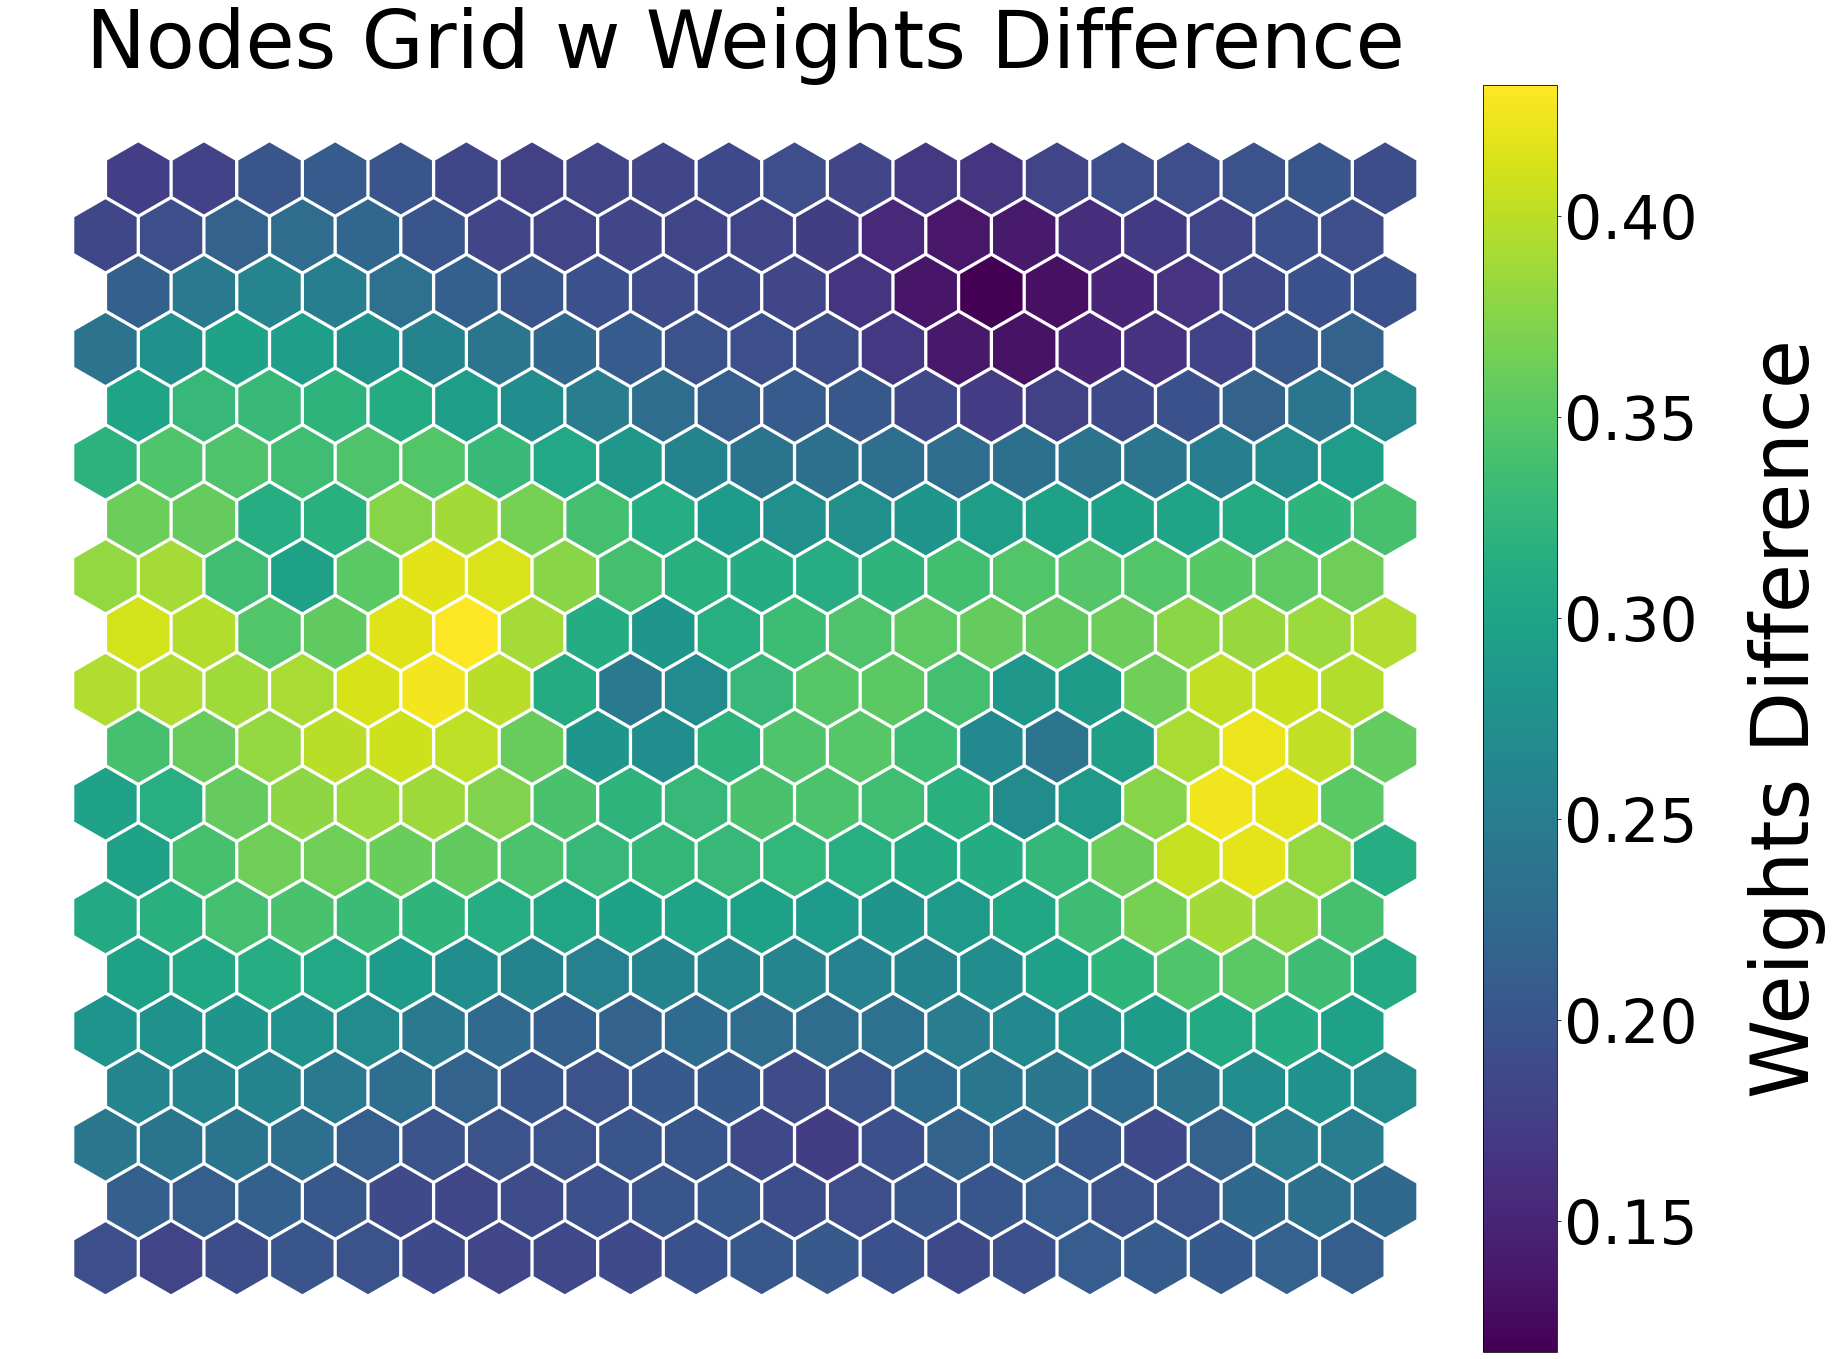

In [54]:
net.diff_graph()

In [55]:
prj= np.array(net.project(reviews_de))

<Figure size 432x288 with 0 Axes>

In [56]:
prod2_som= prod2[['reviewText','rate']].reset_index().drop('index',axis=1)
prod2_som.rename(columns={'rate':'sentiment'},inplace=True)
prod2_som.head()


,reviewText,sentiment
0,"the top of my head is very thin, but with a fe...",1
1,i have been using toppik for several years now...,1
2,even with the spray made to make the fibers st...,-1
3,i was told about your product from a client at...,1
4,i am thinning at the temples due to postpartum...,-1


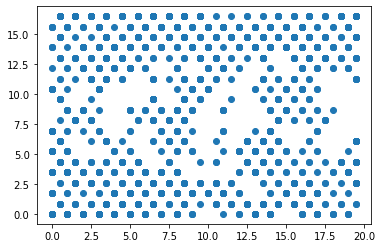

In [57]:
plt.scatter(prj.T[0],prj.T[1])
plt.show()

In [58]:
kmeans= KMeans(n_clusters=2,random_state=True).fit(prj)

In [59]:
prod2_som['prediction']=kmeans.labels_

In [60]:
prod2_som[prod2_som['prediction']==1].head()

,reviewText,sentiment,prediction
0,"the top of my head is very thin, but with a fe...",1,1
1,i have been using toppik for several years now...,1,1
2,even with the spray made to make the fibers st...,-1,1
5,very disappointing product even when you reali...,-1,1
6,bought for a friend,1,1


In [61]:
prod2_som['sentiment']=prod2_som['sentiment'].apply(lambda x: 1 if x==1 else 0)

In [62]:
prod2_som.to_json('prod2_KmeansSOM.json',compression='gzip')

In [63]:
acc=accuracy_score(prod2_som['sentiment'],prod2_som['prediction'])

In [64]:
precision=precision_score(prod2_som['sentiment'],prod2_som['prediction'])

In [65]:
recall=recall_score(prod2_som['sentiment'],prod2_som['prediction'])

In [66]:
f1=f1_score(prod2_som['sentiment'],prod2_som['prediction'])

In [67]:
scores= [acc,precision,recall,f1]
with open("prod2_Kmeans_SOM_scores.txt","w") as f:
  for i in scores:
    f.write("%.2f\n"%i)